In [82]:
import numpy as np
from VAE_modules_20_11 import Decoder
import torch
import torch.nn as nn
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
from neural_renderer import Canvas_env
from torchvision import transforms
import math

In [83]:
def generate_samples(imsize=64,max_radius= 16, num_samples = 128):
    samples = np.zeros([num_samples,imsize,imsize])
    positions = np.random.rand(num_samples,2)
    sizes = np.random.rand(num_samples)
    action = np.stack([positions[:,0],positions[:,1],sizes],axis=1)
    for n,sample in enumerate(samples):
        sample = cv.circle(sample,(positions[n]*imsize).astype(int),(sizes[n]*max_radius).astype(int),1,-1)
    return(samples,action)
samples,action = generate_samples()

In [155]:
renderer = nn.Sequential(Decoder(depths=[1,1,1,1,1,3],dims=[1,4,4,4,4,3]),nn.Sigmoid()).to('cuda:0')

In [154]:
blur_large = transforms.GaussianBlur(31,sigma=(5))


Training

In [177]:
renderer = renderer.train()

mse = nn.MSELoss()

optimizer = torch.optim.Adam(renderer.parameters(), lr=1e-3)
batches = 1000

pbar = tqdm(range(batches))
for n in enumerate(pbar):
    samples, action = generate_samples(imsize=32,num_samples=512)
    decoding = renderer(torch.tensor(action,dtype=torch.float,device='cuda:0').unsqueeze(-1).unsqueeze(-1))
    loss = mse(decoding.squeeze(1),blur_large(torch.tensor(samples,dtype=torch.float,device='cuda:0')))
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    pbar.set_postfix(loss = loss)

100%|██████████| 1000/1000 [00:06<00:00, 152.01it/s, loss=tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)]


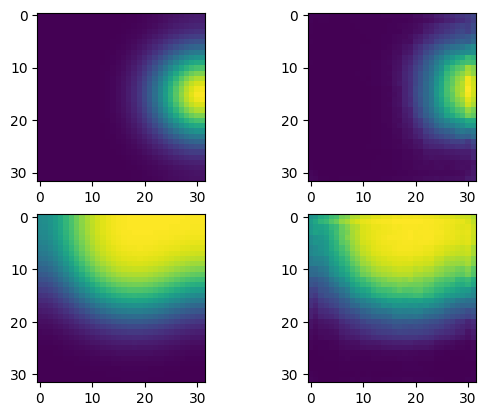

In [181]:
renderer = renderer.eval()
samples, action = generate_samples(imsize=32,num_samples=2)
samples = blur_large(torch.tensor(samples,dtype=torch.float,device='cuda:0'))

decoding = renderer(torch.tensor(action,dtype=torch.float32,device='cuda:0').unsqueeze(-1).unsqueeze(-1))
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(samples[0].detach().cpu())
axs[0,1].imshow(decoding.squeeze(1).detach().cpu()[0])
axs[1,0].imshow(samples[1].detach().cpu())
axs[1,1].imshow(decoding.squeeze(1).detach().cpu()[1])

In [183]:
torch.save(renderer.state_dict(), './nn.Sequential(Decoder(depths=[1,1,1,1,1,3],dims=[1,4,4,4,4,3]),nn.Sigmoid()).pt')